In [1]:
try:
  import tinygp
except ModuleNotFoundError:
  %pip install tinygp
  import tinygp
import jax

try: 
  import flax
except ModuleNotFoundError:
  %pip install flax
  import flax

# jax.config.update("jax_enable_x64", True)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from tinygp import kernels, GaussianProcess
import flax.linen as nn
from flax.linen.initializers import zeros

try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

import optax
import jax.numpy as jnp

key = jax.random.PRNGKey(42)
# jax.config.update("jax_enable_x64", True)

In [2]:
def data(num_points, test_points, key_, noise):

  X =  jnp.linspace(-4, 4, num_points).reshape(-1,1) 
  y = jnp.sin(X)

  test_points = 100
  X_test =  jnp.linspace(-5, 5, test_points).reshape(-1,1) 
  y_test = jnp.sin(X_test)

  if (noise):
    y = y + jax.random.normal(key = key_, shape = (num_points, 1)) * noise**0.5
    y_test = y_test + jax.random.normal(key = key_, shape = (test_points, 1)) * noise**0.5

  return X, y , X_test, y_test

In [3]:
X, y, X_test, y_test = data(7, 100, key, noise = 1.)
X = X.reshape(-1,)
X_test = X_test.reshape(-1, )
y = y.reshape(-1, )


def build_gp(theta, X):
  kernel1 = jnp.exp(theta["log_amp"])*kernels.ExpSquared(scale=jnp.exp(theta["log_scale"]))
  kernel2 = kernels.ExpSineSquared(scale=jnp.exp(theta["log_scale"]), gamma=jnp.exp(theta["log_gamma"]))
  kernel = kernel1

  return GaussianProcess(kernel, X, diag = jnp.exp(theta["log_diag"]))

def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    print(y.shape)
    return -gp.log_probability(y)


theta_init = {
  "log_amp": jnp.log(1.),
  "log_diag": jnp.log(0.45),
  "log_scale": jnp.log(1.33),
  "log_gamma": jnp.log(1.2)}


obj = jax.jit(jax.value_and_grad(neg_log_likelihood))


print(f"Initial negative log likelihood: {obj(theta_init, X, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, X, y)[1]}")

(7,)


2022-06-13 18:54:07.898140: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-06-13 18:54:07.898218: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-06-13 18:54:07.898228: W external/org_tensorflow/tensorflow/stream_executor/stream.cc:1110] attempting to perform BLAS operation using StreamExecutor without BLAS support
2022-06-13 18:54:07.898269: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2141] Execution of replica 0 failed: INTERNAL: Unable to launch triangular solve for thunk 0x555e1bfc2790


XlaRuntimeError: INTERNAL: Unable to launch triangular solve for thunk 0x555e1bfc2790

In [7]:
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
print(X.shape, y.shape)
soln = solver.run(theta_init, X=X, y=y)
print(f"Final negative log likelihood: {soln.state.fun_val}")

Final negative log likelihood: 14.149437044869117


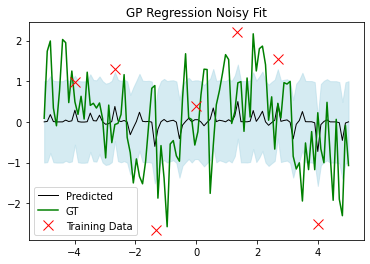

In [5]:
gp = build_gp(soln.params, X)
cond_gp = gp.condition(y, X_test).gp
mu, var = cond_gp.loc, cond_gp.variance

# plt.plot(X, y, ".k")
# plt.fill_between(
#     X_test, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5
# )
# plt.plot(X_test, mu, color="C0", lw=2)

plt.plot(X_test, mu,'k',label='Predicted',lw=1)
plt.plot(X_test, y_test, 'g',label='GT',lw=1.5)
plt.plot(X, y, 'x', c = 'r', markersize=10, label='Training Data')

plt.fill_between(X_test.flatten(), 
                 (mu.flatten() - jnp.sqrt(var)),
                 (mu.flatten() + jnp.sqrt(var)),
                 color='lightblue', alpha=0.5)
plt.legend()
plt.title("GP Regression Noisy Fit")
# plt.savefig("GP_noisy_posterior.png")
plt.show()